<a href="https://colab.research.google.com/github/KTH-EXPECA/summer-school-2025/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Python environment:

In [3]:
!wget -O miniconda.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_25.1.1-2-Linux-x86_64.sh > /dev/null 2>&1
!bash ./miniconda.sh -b -f -p /usr/local > /dev/null 2>&1
!conda install -q -y jupyter google-colab traitlets=5.5.0 -c conda-forge > /dev/null 2>&1
!python -m ipykernel install --name "py39" --user > /dev/null 2>&1
!rm ./miniconda.sh

Now in Google Colab, on the bottom right corner of the page, click on "Python", then  "Change runtime type", then select "Runtime type" to "py39".

After that, run the following to check if it is working:

In [1]:
import sys, subprocess, platform, os
print("Kernel Python:", sys.version)
print("sys.executable:", sys.executable)
subprocess.run([sys.executable, "-m", "pip", "--version"])

Kernel Python: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
sys.executable: /usr/local/bin/python


CompletedProcess(args=['/usr/local/bin/python', '-m', 'pip', '--version'], returncode=0)

Install required dependencies:

In [2]:
# Install Pr3d package with tensorflow, keras, protobuf
!pip install git+https://github.com/samiemostafavi/pr3d.git > /dev/null 2>&1
!pip install -q scipy matplotlib > /dev/null 2>&1
!pip install --upgrade numpy pandas > /dev/null 2>&1

import numpy, pandas
print('NumPy:', numpy.__version__)
print('Pandas:', pandas.__version__)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf, keras, tensorflow_probability as tfp, google.protobuf as protobuf
print('protobuf:', protobuf.__version__)
print('keras:', keras.__version__)
print('tensorflow:', tf.__version__)
print('tensorflow-probability:', tfp.__version__)

NumPy: 1.22.3
Pandas: 1.4.2
protobuf: 3.20.1
keras: 2.8.0
tensorflow: 2.8.0
tensorflow-probability: 0.16.0


Download the datasets:

In [3]:
!mkdir -p /content/data
!curl -L -o /content/data/dataset.zip "https://github.com/KTH-EXPECA/summer-school-2025/raw/refs/heads/main/dataset.zip"
!unzip -q -o /content/data/dataset.zip
!rm -rf /content/data
!rm -rf /content/__MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.5M  100 20.5M    0     0  35.2M      0 --:--:-- --:--:-- --:--:-- 98.0M


Import required packages:

In [7]:
import tensorflow as tf
from pr3d.de import GaussianMM, GaussianMixtureEVM, GammaMixtureEVM

In [2]:
import pickle, json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pkl_path = Path("/content/dataset.pkl")
with open(pkl_path, "rb") as f:
    datasets = pickle.load(f)

for i, item in enumerate(datasets, 1):
    df = pd.DataFrame(item.get("dataset"))
    meta = {k: v for k, v in item.items() if k != "dataset"}

    print(f"\n===== ITEM {i} =====")
    print("META:", meta)
    print(f"DATASET: DataFrame shape={df.shape}, columns:{df.columns}")


===== ITEM 1 =====
META: {'db_id': 0, 'dataset_name': 'e20', 'stream_rnti': '77e2', 'size': 90306, 'arrivals_num': 18061}
DATASET: DataFrame shape=(90306, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 2 =====
META: {'db_id': 1, 'dataset_name': 'e4', 'stream_rnti': 'a431', 'size': 146421, 'arrivals_num': 36602}
DATASET: DataFrame shape=(146421, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 3 =====
META: {'db_id': 2, 'dataset_name': 'e19', 'stream_rnti': '37ff', 'size': 89016, 'arrivals_num': 18058}
DATASET: DataFrame shape=(89016, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_

In [ ]:
df = pd.DataFrame(datasets[0]['dataset'])
df = df.loc[df['segment'] == -1].copy()

df['packet_delay_ms'] = (df['depart_timestamp'].astype(float) - df['timestamp'].astype(float)) * 1000
packet_delays_ms = df['packet_delay_ms'].tolist()

plt.figure(figsize=(10, 4))
plt.plot(df['packet_delay_ms'].values)
plt.xlabel('Time')
plt.ylabel('Packet delay (ms)')
plt.title('Packet delay over time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the same delays column you computed
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()

# Keep only [0, 400] ms for the plot domain
mask = (delays >= 0) & (delays <= 400)
delays_clip = delays[mask]

# Histogram as PDF (area = 1). 2 ms bins across 0–400 ms -> 200 bins
bins = np.linspace(0, 400, 201)
pdf_vals, bin_edges = np.histogram(delays_clip, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, pdf_vals)
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('PDF')
plt.title('Packet Delay Empirical PDF')
plt.grid(True)
plt.tight_layout()
plt.show()

# calculate CCDF
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
delays.sort()                              # ascending
n = delays.size
ccdf = 1.0 - (np.arange(1, n + 1) / n)     # empirical CCDF = 1 - ECDF

# plot CCDF
plt.figure(figsize=(6, 4))
plt.step(delays, ccdf, where='post')       # survival curve style
plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(1e-5, 1)
plt.xlabel('Packet delay (ms)')
plt.ylabel('CCDF  (P[Delay > x])')
plt.title('Packet Delay Empirical CCDF')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()




NameError: name 'pd' is not defined

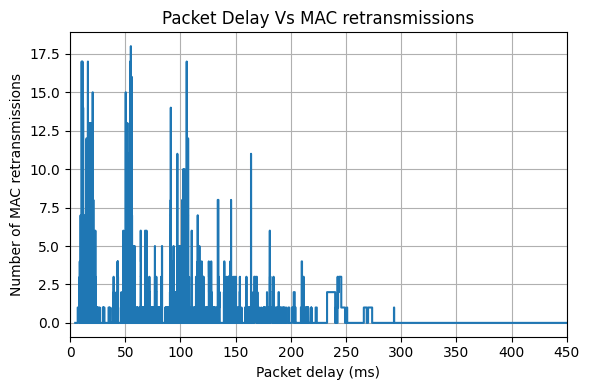

In [ ]:
# Get the no of mac retransmissions
mretx = df['mretx'].tolist()

# plot delay distribution over the number of mac retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, mretx, where='post')       # survival curve style
plt.xlim(0, 450)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of MAC retransmissions')
plt.title('Packet Delay Vs MAC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

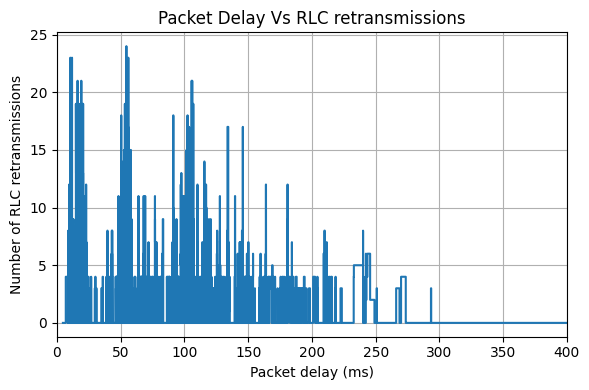

In [ ]:
# Get the no of rlc retransmissions
rlcRetx = df['rfailed'].tolist()

# plot delay distribution over the number of rlc retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, rlcRetx, where='post')       # survival curve style
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of RLC retransmissions')
plt.title('Packet Delay Vs RLC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

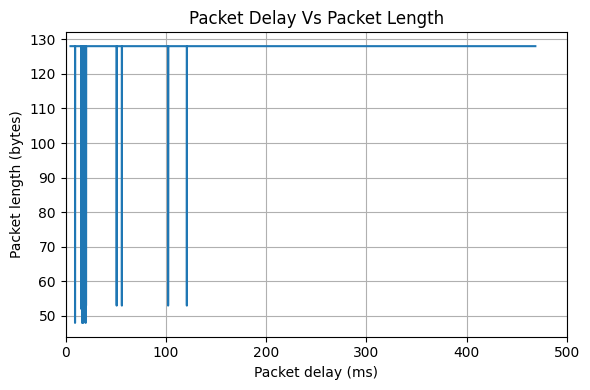

In [ ]:
# Get the packet length
pktLen = df['len'].tolist()

# plot delay distribution over the packet length
plt.figure(figsize=(6, 4))
plt.step(delays, pktLen, where='post')       # survival curve style
plt.xlim(0, 500)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Packet length (bytes)')
plt.title('Packet Delay Vs Packet Length')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()